# <font color ='black'>Twitter sentiment classification using Apache Spark:</font>
#### <font color ='black'>This project is done by
- Nitin Surya (nsurya3)
- Heeba Mohammed Ali (hmoham23)

Abstract: Sentiment analysis is done on the tweets using different machine learning techniques in Apache Spark. The faeatures are extracted from data and supervised learning models are built. The model automatically classifies the tweets as positive or negative. We have used three techniques in our project namely Naive bayes, Logistic Regression and Decision Tree Modeling. We have observed the training accuracy, 5-fold validation accuracy and test accuracy,  F1 measure , precision and recall  and compared them to identify the best classifier amongst these classifiers.</font> 

#### <font color = 'black'> Application dependencies </font>
<font color = 'black'>
<pre>
- Jupyter
- NLTK
- Pyspark
- Numpy
- Matplotlib
</pre>
</font>

#### <font color = 'black'>1. Tweet Processing: </font>
<font color = 'black' > 
a.	All the tweets are passed to a function called get_cleaned_tweet()<br>
b.	Get_cleaned_tweet() internally calls the get_cleaned_word() method which cleans the individual words of the tweet<br>
    &nbsp;&nbsp;&nbsp;i. Uses Porter’s stemmer algorithm for stemming with NLTK library<br>
    &nbsp;&nbsp;&nbsp;ii. Stop words are removed by checking with the custom stop word file, from HW3<br>
    &nbsp;&nbsp;&nbsp;iii. All the words were converted to lower case for simplicity<br>
    &nbsp;&nbsp;&nbsp;iv. Punctuations were stripped<br>
    &nbsp;&nbsp;&nbsp;v. Multiple occurences of character are replaced by 2 occurences<br>
    &nbsp;&nbsp;&nbsp;vi. Hashtags were replaced in the beginning of word. @ mentiones were replaced with 'AT_USER'<br>
    &nbsp;&nbsp;&nbsp;vii. 'http' etc links replaced with 'URL'<br>
    &nbsp;&nbsp;&nbsp;viii. Only words greater than 1 character were included<br>
c.	The cleaned text is passed as a list to feature extraction function<br>
d.	Feature extraction & Transformation is done using:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i.	pyspark.mllib.feature.HashingTF<br>
e.	This is converted into a labelled point and given to the spark context which converts it into an RDD vector<br>
f.	The words are the individual features<br>
</font>

#### <font color = 'black'> 2. Feature Space</font>
<font color = 'black'>
a. The feature space is the set of all words in the tweets<br>
b. We are considering unigrams<br>
c. The size of the feature space:<br>
        &nbsp;&nbsp;&nbsp;i. Entire set of words for NB and LOG<br>
        &nbsp;&nbsp;&nbsp;ii. 100 features for DT<br>
</font>



#### <font color = 'black'>3. Experiment Results: </font>
<font color = 'black'>
<table>
<tr>
<td>Algorithm</td>
<td>Training accuracy</td>
<td>5 fold cross validation accuracy</td>
<td>Test accuracy</td>
<td>Avg precision</td>
</tr>
<tr>
<td>NB</td>
<td> 83% </td>
<td> 74% </td>
<td> 78% </td>
<td> 0.83</td>
</tr>
<tr>
<td>LOG</td>
<td> 70% </td>
<td> 71% </td>
<td> 70% </td>
<td> 0.69</td>
</tr>
<tr>
<td>DT</td>
<td> 61% </td>
<td> 60% </td>
<td> 59% </td>
<td> </td>
</tr>
</table>
</font>
<br/>

#### <font color = 'black'> Evaluation Metrics details </font>
<font color = 'black'>
<pre>
1. Confusion Matrix:
 - "True positive" indicate the prediction model correctly suggested a tweet to be positive.
 - "True negative" indicate the prediction model correctly suggested a tweet to be negative.
 - "False positive" indicate the prediction model incorrectly suggested a tweet to be positive.
 - "False negative" indicate the prediction model incorrectly suggested a tweet to be negative.

2. Precision:
 - The correct tweet, out of all the tweets predicted as positive.
</pre>
</font>

#### <font color = 'black'> Results </font>
<font color = 'black'>
<pre>
After trying Naive bayes, Logistic regression and Decision trees, it was observed that Naive bayes performs best,
as it gave the highest accuracy and precision.

It was also observed that, no significant overfitting was observed, as the accuracy in the training set was
similar to the test set
</pre>
</font>

In [1]:
import json
import csv
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName="first spark based notebook")

NETID = "nsurya3"

In [105]:
%matplotlib inline   # used to display graphs inside the jupyter

# classifiers and regression models used
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel, LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

from pyspark.mllib.linalg import Vectors
# feature extraction options
from pyspark.mllib.feature import HashingTF
# evaluation metrics for getting precision recall, f1 measure, AUC ROC etc.
from pyspark.mllib.evaluation import MulticlassMetrics
# for graphs
import matplotlib.pyplot as plt

import numpy as np

#nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

<font color = 'black'> 
<pre>
Cleaning Pre-steps:
1. The stop words file is read to make a stop word corpus to check for stop words.
2. The NLTK library functions are used to identify Punctuations
3. Porters stemmer algorithm is initilaized for stemming
</pre> </font>

In [3]:
stop_words_file = open('./data/stopwords.txt')
stop_words = []

for word in stop_words_file:
    stop_words.append(word.strip())

# Module-level global variables for the `tokenize` function below
PUNCTUATION = set(string.punctuation)
STOPWORDS = set(stop_words)
STEMMER = PorterStemmer()

### <font color = 'black'>1. displayMetrics function:</font><br/>
<font color = 'black'> This function computes and displays accuracy of the classifier, Precision, Recall, Fmeasure, Area under ROC, Confusion Matrix</font>

In [119]:
# Returns: accuracy, truePositiveRate, falsePositiveRate
def displayMetrics(metrics, predictionAndLabel, test, showMetrics = True):
    accuracy = (1.0 * predictionAndLabel.filter(lambda x: x[0] == x[1]).count() / test.count())

    if(showMetrics):
        print('Confusion Matrix:')
        print(metrics.confusionMatrix().toArray())
        print("Accuracy = %s" % accuracy)
        print("Precision = %s" % metrics.precision())
        # Area under precision-recall curve
        print("Recall = %s" % metrics.recall())
        print("fMeasure = %s" % metrics.fMeasure(0.0))
        print()

    return accuracy, metrics.truePositiveRate(0.0), metrics.falsePositiveRate(0.0)

### <font color = 'black'>2. get_clean_word function:</font><br/>
<font color = 'black'> This function is called to clean the individual words (features) of the tweet during feature extraction process</font>

In [120]:
# Returns a cleaned, and simple letters based word
def get_clean_word(word):    
    while(len(word) > 0 and not (word[0].isalpha() or word[0] in ('#', '@', ':', ';'))): # removing numbers and special chars from beginning
        word = word[1:]
    
    if(len(word) > 0):
        if(word[0] == '@'): # is user ref
            return "AT_USER"
        elif(word.startswith("http:") or word.startswith("https:") or word.startswith("www")): # URLs
            return 'URL'
        elif(word[0] == '#'): # tags
            return word[1:]
        elif(word[0] in [';', ':']):
            return word

    while(len(word) > 0 and not word[-1].isalpha()): # removing numbers and special chars from end
        word = word[0:-1]

    if(len(word) > 0 and (word[0] == '@' or word[0] == '#' or word.startswith("http:") or word.startswith("https:"))):
        return ""
    
    # removing continuous characters e.g. awwww -> aww
    temp_word = word
    word_len = len(temp_word)
    prev_index, word = 0, ""
    for index, char in enumerate(temp_word):
        if index == 0:
            word = word + char
            continue
        
        if(temp_word[index - 1] == temp_word[index]):
            continue
        else:
            if(index - prev_index >= 2):
                word = word + temp_word[index-1]

            prev_index = index
            word = word + char

    # for last character handling
    if(len(temp_word) - 1 - prev_index >= 2):
        word = word + temp_word[index-1]
    
    word = STEMMER.stem(word) # finally stemming the word using nltk stemmer

    return word.lower()

### <font color = 'black'>3. get_cleaned_tweet function:</font><br/>
<font color = 'black'> This function returns LabeledPoint Hashedtf of final cleaned words, and polarity.</font> 

In [166]:
# returns array of final cleaned words, the original json text and the complete tweet json parsed
def get_cleaned_tweet(tweet_csv_line, get_id = False):
    tweet_csv_line = tweet_csv_line.strip().split(',')
    tweet_obj = ','.join(tweet_csv_line[5:])[1:-1]
    label = float(tweet_csv_line[0].strip('"'))
    json_format=False
    tweet_json = {'text': tweet_obj}
    tweet_text = tweet_obj

    parsed_tweet = tweet_text.strip().replace(',', ' ').split()
    final_words = []
    for word in parsed_tweet:
        if word in STOPWORDS:
            continue

        word = get_clean_word(word)
        if len(word) > 2:
            final_words.append(word)

    words_vector = hashingTF.transform(final_words)
    labelled_point = LabeledPoint(label, words_vector)
    if(get_id):
        return [tweet_obj, labelled_point]
    else:
        return labelled_point

### <font color = 'black'>4. Naive bayes function</font><br/>
<font color = 'black'> Creates a model using training data if not present.
Setting the metrics and preciation and label variables</font> 

In [121]:
def naiveBayes(training, test, model=None):
    if(model == None):
        model = NaiveBayes.train(training, 1.0)
    predictionAndLabel = test.map(lambda p: (float(model.predict(p.features)), p.label))
    metrics = MulticlassMetrics(predictionAndLabel)
    return displayMetrics(metrics, predictionAndLabel, test), model

<font color = 'black'>Training the model with the train data</font> 

In [126]:
hashingTF = HashingTF()
data = sc.textFile('./data/train.csv', use_unicode=True).map(get_cleaned_tweet)
#idf = IDF()
#model = idf.fit(data)
training, test = data, data.sample(False, 0.3)
(acc_val, actual, predication), naiveBayesModel = naiveBayes(training, test)

Confusion Matrix:
[[ 10089.   1938.]
 [  2249.   9932.]]
Accuracy = 0.827040647719762
Precision = 0.827040647719762
Recall = 0.827040647719762
fMeasure = 0.8281551405704904



<font color = 'black'>Testing the model with the test data</font> 

In [127]:
hashingTF = HashingTF()
testcsv_data = sc.textFile('./data/test.csv', use_unicode=True).map(get_cleaned_tweet)
(acc_val, actual, predication), model = naiveBayes([], testcsv_data, naiveBayesModel)

Confusion Matrix:
[[ 140.   37.]
 [  41.  141.]]
Accuracy = 0.7827298050139275
Precision = 0.7827298050139275
Recall = 0.7827298050139275
fMeasure = 0.782122905027933



<font color = 'black'> 5 fold validation of a naive Bayes model</font> 

In [178]:
hashingTF = HashingTF()
data = sc.textFile('./data/train.csv', use_unicode=True).map(get_cleaned_tweet)
kfold_test = data.randomSplit([0.2,0.2,0.2,0.2,0.2])
acc_sum = 0
for i in range(5):
    test_set = kfold_test[i]
    combined_set = None
    for j in range(5):
        if j != i:
            if(combined_set != None):
                combined_set = combined_set + kfold_test[j]
            else:
                combined_set = kfold_test[j]

    training = combined_set
    test = test_set
    (acc_val, actual, predication), model = naiveBayes(training, test)
    acc_sum = acc_sum + acc_val

print("avg accuracy = {}".format(acc_sum/5))

Confusion Matrix:


KeyboardInterrupt: 

### <font color = 'black'>5. Logistic Regression function</font><br/>
<font color = 'black'> Train a Logistic Regression model if not present from the parsed data. Also create the metrics and prediction and label variable</font> 

In [148]:
# logistic regression
def logisticRegression(parsedData, test, model=None, showMetrics = True):
    if(model == None):
        model = LogisticRegressionWithLBFGS.train(parsedData)
    predictionAndLabel = test.map(lambda p: (float(model.predict(p.features)), p.label))
    metrics = MulticlassMetrics(predictionAndLabel)
    return displayMetrics(metrics, predictionAndLabel, test, showMetrics), model

<font color = 'black'> Training the model</font> 

In [150]:
hashingTF = HashingTF(numFeatures=600)
data = sc.textFile('./data/train.csv', use_unicode=True).map(get_cleaned_tweet)
parsedData, test = data, data.randomSplit([0.3, 0.8])[0]
(acc_val, actual, predication), logistic_model = logisticRegression(parsedData, test)
model = logistic_model

Confusion Matrix:
[[ 7321.  3607.]
 [ 3137.  7876.]]
Accuracy = 0.6926302356319219
Precision = 0.6926302356319219
Recall = 0.6926302356319219
fMeasure = 0.684653511643131



<font color = 'black'> Testing the model on train data</font> 

Confusion Matrix:
[[ 115.   62.]
 [  43.  139.]]
Accuracy = 0.7075208913649025
Precision = 0.7075208913649025
Recall = 0.7075208913649025
fMeasure = 0.6865671641791045



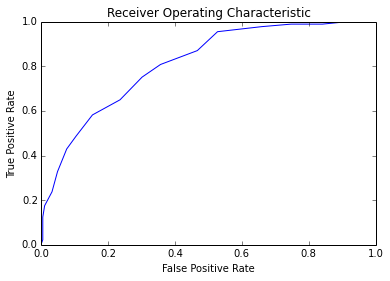

In [125]:
hashingTF = HashingTF(numFeatures=600)
testcsv_data = sc.textFile('./data/test.csv', use_unicode=True).map(get_cleaned_tweet)
(acc_val, actual, predication), model = logisticRegression([], testcsv_data, model)

x_val = []
y_val = []
for i in np.arange(0, 1, 0.05):
    model.setThreshold(i)
    (acc_val, actual, predication), model = logisticRegression([], testcsv_data, model, False)
    x_val.append(actual)
    y_val.append(predication)

plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(y_val, x_val, label='AUC')

#plt.plot([0,1],[0,1],'r--')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()

<font color = 'black'> 5 fold validation of a Logistic Regression model</font> 

In [21]:
hashingTF = HashingTF(numFeatures=600)
data = sc.textFile('./data/train.csv', use_unicode=True).map(get_cleaned_tweet)
kfold_test = data.randomSplit([0.2,0.2,0.2,0.2,0.2])
acc_sum = 0
for i in range(5):
    test_set = kfold_test[i]
    combined_set = None
    for j in range(5):
        if j != i:
            if(combined_set != None):
                combined_set = combined_set + kfold_test[j]
            else:
                combined_set = kfold_test[j]

    training = combined_set
    test = test_set
    (acc_val, actual, predication), model = logisticRegression(training, test)
    acc_sum = acc_sum + acc_val

print("avg accuracy = {}".format(acc_sum/5))

Accuracy = 0.6927790763787984
Area under PR = 0.7716010159197145
Area under ROC = 0.6927310577926814
Accuracy = 0.6904003497595403
Area under PR = 0.7689782103134173
Area under ROC = 0.6904606154617405
Accuracy = 0.6943204365079365
Area under PR = 0.7759894355349097
Area under ROC = 0.6939676262434082
Accuracy = 0.6907371453623098
Area under PR = 0.7655298309226914
Area under ROC = 0.691090265377512
Accuracy = 0.6992219109866169
Area under PR = 0.776348738286206
Area under ROC = 0.6991761077541239
avg accuracy = 0.6934917837990404


### <font color = 'black'>6. a. Decision tree Modelling function</font><br/>
<font color = 'black'> Train a Decision Tree model</font> 

In [179]:
# Decision tree
def decisionTree(parsedData, test_decision_tree, model = None):
    if(model == None):
        model = DecisionTree.trainClassifier(parsedData, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=5, maxBins=20)
    predictions = model.predict(test_decision_tree.map(lambda x: x.features))
    predictionAndLabel = predictions.zip(test_decision_tree.map(lambda lp: lp.label))
    metrics = MulticlassMetrics(predictionAndLabel)
    return displayMetrics(metrics, predictionAndLabel, test_decision_tree), model

<font color = 'black'> Training the model</font> 

In [180]:
# reducing the features length 
hashingTF = HashingTF(numFeatures=250)
data = sc.textFile('./data/train.csv', use_unicode=True).map(get_cleaned_tweet)
parsedData, test_decision_tree = data, data.randomSplit([0.3, 0.8])[0]

# train using logistic regression
(acc_val, actual, predication), model = decisionTree(parsedData, test_decision_tree)

Confusion Matrix:
[[ 6432.  4604.]
 [ 4044.  6912.]]
Accuracy = 0.6067660967624591
Precision = 0.6067660967624591
Recall = 0.6067660967624591
fMeasure = 0.5979918185198959



<font color = 'black'> Testing the model</font> 

In [54]:
hashingTF = HashingTF(numFeatures=250)
testcsv_data = sc.textFile('./data/test.csv', use_unicode=True).map(get_cleaned_tweet)
(acc_val, actual, predication), model = decisionTree([], testcsv_data, model)

Accuracy = 0.5877437325905293
Area under PR = 0.6908811360413032
Area under ROC = 0.5882069907493637


<font color = 'black'> 5 fold validation of a Decision tree model</font> 

In [25]:
hashingTF = HashingTF(numFeatures=200)
data = sc.textFile('./data/train.csv', use_unicode=True).map(get_cleaned_tweet)
kfold_test = data.randomSplit([0.2,0.2,0.2,0.2,0.2])
acc_sum = 0
for i in range(5):
    test_set = kfold_test[i]
    combined_set = None
    for j in range(5):
        if j != i:
            if(combined_set != None):
                combined_set = combined_set + kfold_test[j]
            else:
                combined_set = kfold_test[j]

    training = combined_set
    test = test_set
    (acc_val, actual, predication), model = decisionTree(training, test)
    acc_sum = acc_sum + acc_val

print("avg accuracy = {}".format(acc_sum/5))

Accuracy = 0.6038404175988069
Area under PR = 0.6945628137256861
Area under ROC = 0.6035146013460227
Accuracy = 0.6055791843882912
Area under PR = 0.7135876420177848
Area under ROC = 0.6051795695959857
Accuracy = 0.5991864831038799
Area under PR = 0.6941113291793948
Area under ROC = 0.5990697852425196
Accuracy = 0.6034169847925402
Area under PR = 0.7076648984786549
Area under ROC = 0.6038348193791004
Accuracy = 0.6084205250297601
Area under PR = 0.6970684464903896
Area under ROC = 0.6079916929418651
avg accuracy = 0.6040887189826556


In [177]:
hashingTF = HashingTF(numFeatures=600)
testcsv_data = sc.textFile('./data/test.csv', use_unicode=True).map(lambda line: get_cleaned_tweet(line, True))
logistic_model.clearThreshold()
predicted_data = testcsv_data.map(lambda p: (float(logistic_model.predict(p[1].features)), (p[1].label, p[0])))
top5_correct_tweets = [x[1][1] for x in predicted_data.sortByKey(ascending=False).filter(lambda x: x[1][0] == 1).top(5)]
print("Top 5 correctly predicted tweets:")
print("--------------------")
for tweet in top5_correct_tweets:
    print(tweet)

print()
low5_correct_tweets = [x[1][1] for x in predicted_data.sortByKey(ascending=False).filter(lambda x: x[1][0] == 0).top(5)]
print("Top 5 incorrectly predicted tweets:")
print("--------------------")
for tweet in low5_correct_tweets:
    print(tweet)
print()

Top 5 correctly predicted tweets:
--------------------
@faithbabywear Ooooh, what model are you getting??? I have the 40D and LOVE LOVE LOVE LOVE it!
@sketchbug Lebron is a hometown hero to me, lol I love the Lakers but let's go Cavs, lol
@sklososky Thanks so much!!! ...from one of your *very* happy Kindle2 winners ; ) I was so surprised, fabulous. Thank you! Best, Kathleen
@googleio http://twitpic.com/62shi - Yay! Happy place! Place place!  I love Google!
@mashable I never did thank you for including me in your Top 100 Twitter Authors! You Rock! (&amp; I New Wave :-D) http://bit.ly/EOrFV

Top 5 incorrectly predicted tweets:
--------------------
Back from seeing 'Star Trek' and 'Night at the Museum.' 'Star Trek' was amazing, but 'Night at the Museum' was; eh.
Life?s a bitch? and so is Dick Cheney. #p2 #bipart #tlot #tcot #hhrs #GOP #DNC http://is.gd/DjyQ
Monday already. Iran may implode. Kitchen is a disaster. @annagoss seems happy. @sebulous had a nice weekend and @goldpanda is great.